# Data Preprocessing

After having identified some issues of the training dataset in the EDA phase, we will now proceed to preprocess the data.

In [86]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer

import problexity as pbx
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [87]:
# to be deleted (load the dataset to variable df)
os.chdir('../data')
df = pd.read_csv('customer.csv')

Once the data cleaning process must be applied to both training and test datasets, we will create a function to ensure that we are applying the same transformations to both datasets.

The function must perform the following tasks:
- Remove unnecessary columns
- Deal with outliers
- Scale numerical features (considering Standard Scaling and Min-Max Scaling)
- Encode categorical features (considering Label Encoding and One-Hot Encoding)
- Treat missing values

In [88]:
def preprocess(data, isTest = False):
    # is_employed null values are filled with False
    # data['is_employed'] = data['is_employed'].fillna(False)

    # drop columns 
    cols_to_drop = ['Unnamed: 0','custid','code_column']
    if isTest:
        cols_to_drop.append('health_ins')
    data = data.drop(cols_to_drop, axis=1)

    # put ages < 21 and > 99 to Nan
    data['age'] = data['age'].apply(lambda x: x if 21 <= x <= 99 else None)
    
    # min max scaling for age [0-10]
    min_max_columns = ['age']
    minmax_scaler = MinMaxScaler()
    data[min_max_columns] = minmax_scaler.fit_transform(data[min_max_columns]).round(4)*10
    
    # log normalization
    log_columns = ['income', 'gas_usage']
    data[log_columns] = data[log_columns].apply(lambda x: np.log1p(x - x.min() + 1)).round(4)
    
    # label encoding
    cols_label_encode = ['sex','is_employed','state_of_res']
    if not isTest:
        cols_label_encode.append('health_ins')
    label_encoder = LabelEncoder()
    for col in cols_label_encode:
        data[col] = label_encoder.fit_transform(data[col])

    # one hot encoding
    cols_one_hot_encode = ['marital_status', 'housing_type', 'is_employed']
    data = pd.get_dummies(data, columns=cols_one_hot_encode, dummy_na=False)
    dummies = list(filter(lambda x: x.startswith(tuple(cols_one_hot_encode)), data.columns))
    for col in dummies:
        data[col] = label_encoder.fit_transform(data[col])
    
    # scale the state_of_res column
    data['state_of_res'] = MinMaxScaler().fit_transform(data[['state_of_res']])

    # encode recent_move_b with label encoder but let the nan values as they are
    data['recent_move_b'] = label_encoder.fit_transform(data['recent_move_b'])
    data['recent_move_b'] = data['recent_move_b'].replace(2, None)

    knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
    df_imputed = knn_imputer.fit_transform(data)
    df_imputed = pd.DataFrame(df_imputed, columns=data.columns)
    return df_imputed

Now we can apply the preprocessing steps to the training dataset.

In [89]:
df = preprocess(df)
df.head(10)

,sex,income,health_ins,num_vehicles,age,state_of_res,gas_usage,recent_move_b,marital_status_Divorced/Separated,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner free and clear,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,is_employed_0,is_employed_1,is_employed_2
0,1.0,-0.3412,1.0,0.0,0.04410,0.0,2.6726,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,-0.3206,1.0,0.0,0.89710,0.0,-0.6054,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,-0.3583,1.0,2.0,0.14710,0.0,-0.0195,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,-0.0706,1.0,1.0,0.77734,0.0,1.2474,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,-0.0494,1.0,2.0,0.67650,0.0,-0.6054,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,1.0,-0.5282,1.0,2.0,0.80880,0.0,2.5142,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,-0.2760,0.0,2.0,0.07350,0.0,-0.6054,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,0.0,-0.1250,1.0,2.0,0.76470,0.0,0.1389,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,-0.2897,1.0,5.0,0.08820,0.0,-0.6054,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1.0,-0.1833,1.0,3.0,0.48530,0.0,-0.3362,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [90]:
# Columns after preprocessing
df.columns.to_list()

['sex',
 'income',
 'health_ins',
 'num_vehicles',
 'age',
 'state_of_res',
 'gas_usage',
 'recent_move_b',
 'marital_status_Divorced/Separated',
 'marital_status_Married',
 'marital_status_Never married',
 'marital_status_Widowed',
 'housing_type_Homeowner free and clear',
 'housing_type_Homeowner with mortgage/loan',
 'housing_type_Occupied with no rent',
 'housing_type_Rented',
 'is_employed_0',
 'is_employed_1',
 'is_employed_2']

In [91]:
# No missing values
df.isnull().sum().sum()

np.int64(0)

# Model experimentation

In this section, we will experiment, for the first time, some classification models on the preprocessed dataset. 

In order to have a simple baseline, we will employ simple classification algorithms that are easy to interpret and understand. We will use the following models:
- Decision Tree
- Random Forest
- K-Nearest Neighbors

The objective of this section is to get a sense of how the models perform on the dataset to identify potential candidates for further optimization, or find a problem with the data that needs to be addressed before proceeding to more complex models.

We will also perform some hyperparameter tuning on the models to see how their performance can be improved with some optimization. The following parameters will be tuned:
- Decision Tree: `max_depth`
- Random Forest: `n_estimators`
- K-Nearest Neighbors: `n_neighbors`

In order to get some performance metrics, we will divide the training data into a training and validation sets (70% - 30%), and use the valdation set to evaluate the models.

In [92]:
# Split the data into train and test
X = df.drop('health_ins', axis=1)
y = df['health_ins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

Each model will be evaluated using the following metrics:
- Accuracy
- Precision
- Recall
- F1 Score
- Specificity
- Confusion Matrix

For different hyperparameters, we will store the results in a DataFrame to compare the performance of the models. Then, for the best model of each type, we will store its metrics in another Dataframe to later compare the different algorithms.

In [93]:
# Function to, given the prediction of a model, return its performance metrics
def get_metrics(y_pred):
    acc = round(accuracy_score(y_test, y_pred),3)
    prec = round(precision_score(y_test, y_pred),3)
    rec = round(recall_score(y_test, y_pred),3)
    f1 = round(f1_score(y_test, y_pred),3)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    spec = round(tn / (tn+fp),3)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'specificity': spec, 'cm': cm}

In [94]:
models = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])

For a better visualization of hyperparameters impact on the performance of these models, we will plot the performance metrics for different values of the hyperparameters using the following function:

In [95]:
def plot_measures(measures):
    parameters = measures.iloc[:,0]
    accuracy = measures.iloc[:,1]
    precision = measures.iloc[:,2]
    recall = measures.iloc[:,3]
    f1 = measures.iloc[:,4]
    spec = measures.iloc[:,5]

    sns.lineplot(x=parameters, y=accuracy, label='accuracy')
    sns.lineplot(x=parameters, y=precision, label='precision')
    sns.lineplot(x=parameters, y=recall, label='recall')
    sns.lineplot(x=parameters, y=f1, label='f1')
    sns.lineplot(x=parameters, y=spec, label='specificity')

## Decision Tree

Fitting model with 1
Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with None
None generates the following depth: 34


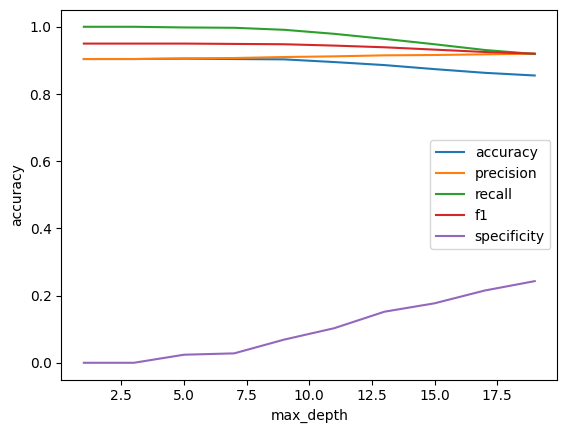

In [96]:
dt_measures = pd.DataFrame(columns=['max_depth', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(1, 20, 2)) + [None]

for max_depth in parameters:
    print(f'Fitting model with {max_depth}')
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'max_depth': max_depth, **measures}
    dt_measures.loc[len(dt_measures)] = new_row

    if max_depth == None:
        print(f'None generates the following depth: {model.get_depth()}')


plot_measures(dt_measures)

In [97]:
# Choose decision tree with max_depth = 9
row = dt_measures[dt_measures['max_depth'] == 9]
models.loc[len(models)] = {'model': 'Decision Tree', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.903,0.91,0.991,0.948,0.069,"[[144, 1932], [184, 19478]]"


## Random Forest

Fitting model with 10
Fitting model with 20
Fitting model with 50
Fitting model with 75
Fitting model with 100
Fitting model with 200
Fitting model with 500


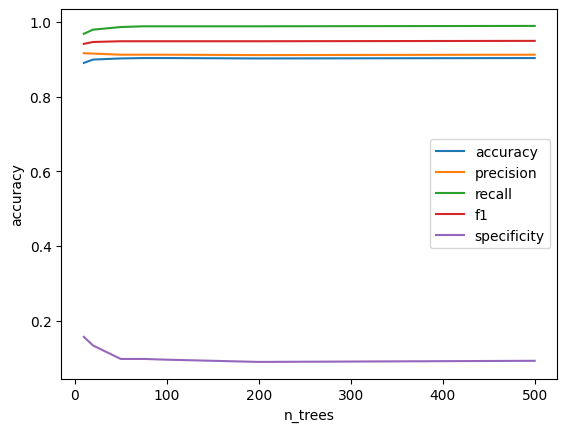

In [98]:
rf_measures = pd.DataFrame(columns=['n_trees', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = [10, 20, 50, 75, 100, 200, 500]

for n_trees in parameters:
    print(f'Fitting model with {n_trees}')
    model = RandomForestClassifier(n_estimators=n_trees)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_trees': n_trees, **measures}
    rf_measures.loc[len(rf_measures)] = new_row

plot_measures(rf_measures)

In [99]:
# Choose random forest with n_trees = 100
row = rf_measures[rf_measures['n_trees'] == 100]
models.loc[len(models)] = {'model': 'Random Forest', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.903,0.910,0.991,0.948,0.069,"[[144, 1932], [184, 19478]]"
1,Random Forest,0.903,0.912,0.988,0.948,0.096,"[[199, 1877], [242, 19420]]"


## K-Nearest Neighbors

Fitting model with 3
Fitting model with 5
Fitting model with 7
Fitting model with 9
Fitting model with 11
Fitting model with 13
Fitting model with 15
Fitting model with 17
Fitting model with 19
Fitting model with 21
Fitting model with 23


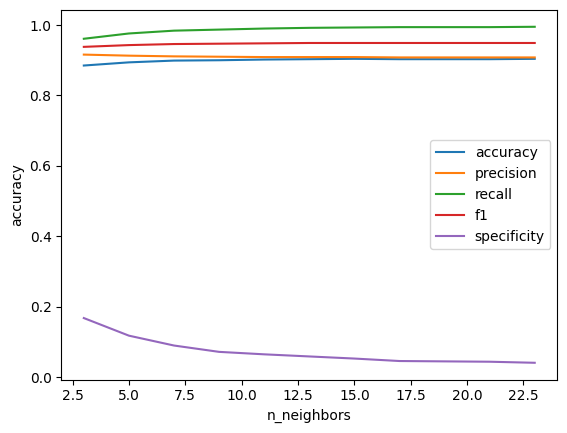

In [100]:
knn_measures = pd.DataFrame(columns=['n_neighbors', 'accuracy', 'precision', 'recall', 'f1', 'specificity', 'cm'])
parameters = list(range(3, 25, 2))

for n_neighbors in parameters:
    print(f'Fitting model with {n_neighbors}')
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    measures = get_metrics(y_pred)
    new_row = {'n_neighbors': n_neighbors, **measures}
    knn_measures.loc[len(knn_measures)] = new_row

plot_measures(knn_measures)

In [101]:
# Choose KNN with n_neighbors = 11
row = knn_measures[knn_measures['n_neighbors'] == 11]
models.loc[len(models)] = {'model': 'KNN', **row.iloc[0,1:]}
models

,model,accuracy,precision,recall,f1,specificity,cm
0,Decision Tree,0.903,0.910,0.991,0.948,0.069,"[[144, 1932], [184, 19478]]"
1,Random Forest,0.903,0.912,0.988,0.948,0.096,"[[199, 1877], [242, 19420]]"
2,KNN,0.902,0.909,0.990,0.948,0.065,"[[134, 1942], [196, 19466]]"


## Overall comparison of the models

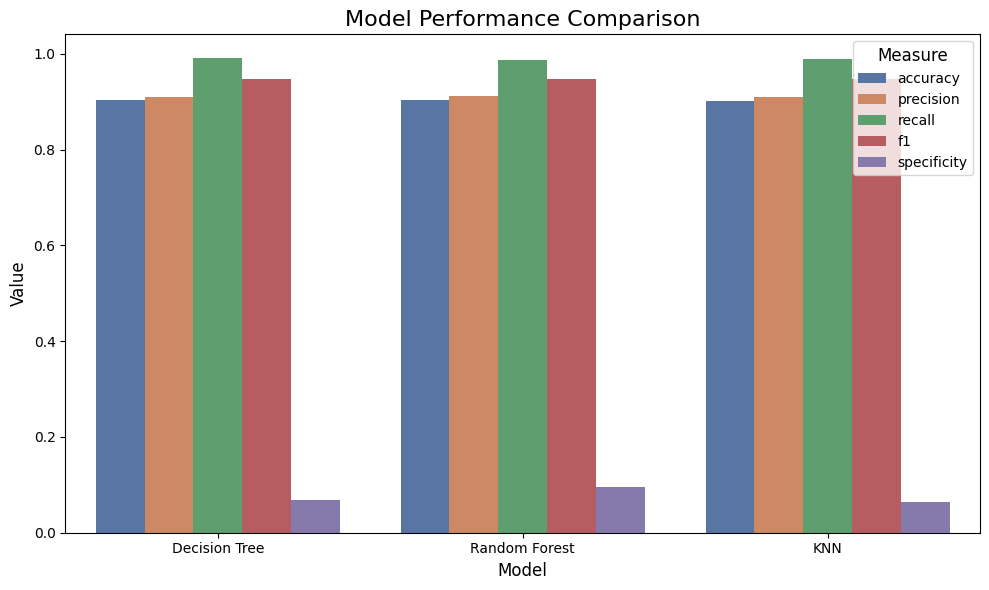

In [102]:
melted = models.melt(id_vars="model", value_vars=["accuracy", "precision", "recall", "f1", "specificity"],
                     var_name="measure", value_name="value")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="model", y="value", hue="measure", palette="deep")
plt.title("Model Performance Comparison", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Measure", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

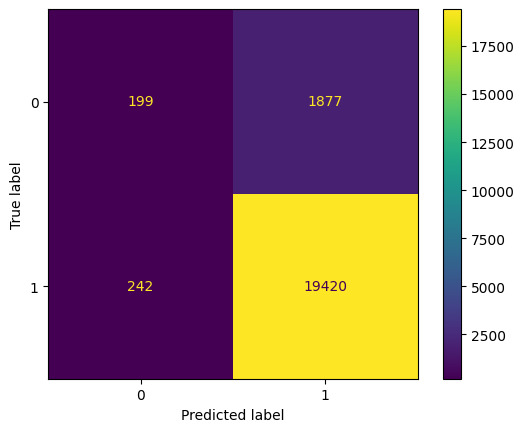

In [103]:
# plot confusion matrix of random forest
rf_cm = models[models['model'] == 'Random Forest']['cm'].values[0]
ConfusionMatrixDisplay(rf_cm).plot()

As we can see, these models seem to perform very well. All of them achieve accuracy, F1-score, recall and precision around 0.9.

Does this mean that we can move forward to more complex models? Not at all.
All these models are getting very low values for specificity and very few cases of True Negatives, meaning they are not good at capturing the negative class. This indicates the presence of very underfitted models, biased towards the positive class.

The confusion matrices resulting of each of these models prove that these models are not capable of correclty predicting a considerbale amount of negative cases.

In [104]:
# Frequency of target variable
print(y.value_counts())

# Frequency of target variable in percentage
print(y.value_counts(normalize=True))

health_ins
1.0    65553
0.0     6905
Name: count, dtype: int64
health_ins
1.0    0.904703
0.0    0.095297
Name: proportion, dtype: float64


Once we are using the trainig dataset to both train and validate our models, the "classical" metrics are not enough to reason about model performance. 

This dataset is highly imbalanced, meaning that both test and validation partitions (generated from itself) will have a similar distribution. So, if we use a model that learns to predict everything as positive, when tested in a dataset with similar distribution, it will achieve very good accuracy, F1, ... metrics.

In [105]:
# Frequency of target variable in train partition
print(y_train.value_counts(dropna=False, normalize=True))

# Frequency of target variable in test partition
print(y_test.value_counts(dropna=False, normalize=True))

health_ins
1.0    0.904791
0.0    0.095209
Name: proportion, dtype: float64
health_ins
1.0    0.904499
0.0    0.095501
Name: proportion, dtype: float64


Next section will focus on how to address this issue, by aplying balacing techniques to the dataset.

# Dealing with imbalanced data

In this section, we will apply some SMOTE techniques to the training data in order to solve the highly imbalanced data problem.

We will try several SMOTE techniques to generate some datasets. Then, these datasets will be compared according to their data-quality metrics (using `problexity` library)

The SMOTE techniques that we will use are:
- **Borderline SMOTE** (over-sampling the minority class reinforcing the border between the classes)
- **ADASYN** (Adaptive Synthetic Sampling: focuses on generating samples of minotiy class that are harder to classify)
- **SMOTE-TL** (SMOTE Tomek Links: combines over-sampling of the minority class with under-sampling of the majority class by removing Tomek links)
- **SMOTE-ENN** (SMOTE Edited Nearest Neighbors: combines over-sampling of the minority class with under-sampling of the majority class by cleaning the majority class with ENN)
- **SVM-SMOTE** (SMOTE Support Vector Machine: uses SVM to generate synthetic samples)

In [106]:
def print_target_dist(y, dataset_name):
    print(f"Frequency in {dataset_name} dataset: {y.value_counts()}")
    print(f"Percentage in {dataset_name} dataset: {y.value_counts(normalize=True).round(3)}")

In [107]:
# Number of cases and percentage of each class in the original dataset
print_target_dist(y, 'original')

Frequency in original dataset: health_ins
1.0    65553
0.0     6905
Name: count, dtype: int64
Percentage in original dataset: health_ins
1.0    0.905
0.0    0.095
Name: proportion, dtype: float64


## SMOTE Edited Nearest Neighbors (SMOTE-ENN)

In [108]:
X_smoteenn, y_smoteenn = SMOTEENN(random_state=42,n_jobs=-1).fit_resample(X, y)
print_target_dist(y_smoteenn, 'SMOTE-ENN')

/Users/fpana/opt/anaconda3/envs/icd/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in SMOTE-ENN dataset: health_ins
0.0    55172
1.0    45223
Name: count, dtype: int64
Percentage in SMOTE-ENN dataset: health_ins
0.0    0.55
1.0    0.45
Name: proportion, dtype: float64


## SMOTE Tomek Links (SMOTE-TL)

In [109]:
X_smotetl, y_smotetl = SMOTETomek(random_state=42,n_jobs=-1).fit_resample(X, y)
print_target_dist(y_smotetl, 'SMOTE-TomekLinks')

/Users/fpana/opt/anaconda3/envs/icd/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in SMOTE-TomekLinks dataset: health_ins
1.0    63814
0.0    63814
Name: count, dtype: int64
Percentage in SMOTE-TomekLinks dataset: health_ins
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


## Borderline SMOTE

In [110]:
X_borderline, y_borderline = BorderlineSMOTE(random_state=42,n_jobs=-1).fit_resample(X, y)
print_target_dist(y_borderline, 'BorderlineSMOTE')

/Users/fpana/opt/anaconda3/envs/icd/lib/python3.12/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in BorderlineSMOTE dataset: health_ins
1.0    65553
0.0    65553
Name: count, dtype: int64
Percentage in BorderlineSMOTE dataset: health_ins
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


## Borderline SMOTE over SMOTE-ENN

In [111]:
X_enn_borderline, y_enn_borderline = BorderlineSMOTE(random_state=42,n_jobs=-1).fit_resample(X_smoteenn, y_smoteenn)
print_target_dist(y_enn_borderline, 'SMOTE-ENN + BorderlineSMOTE')

/Users/fpana/opt/anaconda3/envs/icd/lib/python3.12/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in SMOTE-ENN + BorderlineSMOTE dataset: health_ins
0.0    55172
1.0    55172
Name: count, dtype: int64
Percentage in SMOTE-ENN + BorderlineSMOTE dataset: health_ins
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


## ADASYN

In [112]:
X_adasyn, y_adasyn = ADASYN(random_state=42,n_jobs=-1).fit_resample(X, y)
print_target_dist(y_adasyn, 'ADASYN')

/Users/fpana/opt/anaconda3/envs/icd/lib/python3.12/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in ADASYN dataset: health_ins
0.0    66830
1.0    65553
Name: count, dtype: int64
Percentage in ADASYN dataset: health_ins
0.0    0.505
1.0    0.495
Name: proportion, dtype: float64


## SVM-SMOTE

In [113]:
X_svm_smote, y_svm_smote = SVMSMOTE(random_state=42,n_jobs=-1).fit_resample(X, y)
print_target_dist(y_svm_smote, 'SVM-SMOTE')

/Users/fpana/opt/anaconda3/envs/icd/lib/python3.12/site-packages/imblearn/over_sampling/_smote/filter.py:437: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Frequency in SVM-SMOTE dataset: health_ins
1.0    65553
0.0    65553
Name: count, dtype: int64
Percentage in SVM-SMOTE dataset: health_ins
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


## Comparison of the datasets

In [114]:
datasets = {
    'smote-enn': (X_smoteenn, y_smoteenn),
    'borderline': (X_borderline, y_borderline),
    'smote-tl': (X_smotetl, y_smotetl),
    'enn-borderline': (X_enn_borderline, y_enn_borderline),
    'adasyn-smote': (X_adasyn, y_adasyn),
    'svm-smote': (X_svm_smote, y_svm_smote)
}

fb_measures = pd.DataFrame([], columns=['dataset', 'f1', 'f2', 'f3', 'f4'])

for dataset, (X, y) in datasets.items():
    print(f'Calculating metrics for {dataset}')
    f1 = round(pbx.f1(X, y),3)
    f2 = round(pbx.f2(X, y),3)
    f3 = round(pbx.f3(X, y),3)
    f4 = round(pbx.f4(X, y),3)
    fb_measures.loc[len(fb_measures)] = [dataset, f1, f2, f3, f4]

fb_measures

Calculating metrics for smote-enn
Calculating metrics for borderline
Calculating metrics for smote-tl
Calculating metrics for enn-borderline
Calculating metrics for adasyn-smote
Calculating metrics for svm-smote


,dataset,f1,f2,f3,f4
0,smote-enn,0.663,0.282,0.996,0.995
1,borderline,0.772,0.289,0.997,0.997
2,smote-tl,0.785,0.289,0.997,0.997
3,enn-borderline,0.728,0.282,0.996,0.996
4,adasyn-smote,0.807,0.289,0.997,0.997
5,svm-smote,0.744,0.003,0.988,0.963


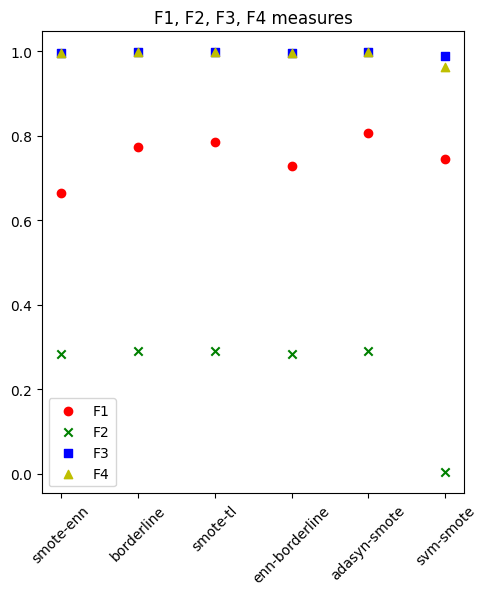

In [115]:
# Plot feature based measures
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(fb_measures['dataset'], fb_measures['f1'], color='r', label='F1', marker='o')
plt.scatter(fb_measures['dataset'], fb_measures['f2'], color='g', label='F2', marker='x')
plt.scatter(fb_measures['dataset'], fb_measures['f3'], color='b', label='F3', marker='s')
plt.scatter(fb_measures['dataset'], fb_measures['f4'], color='y', label='F4', marker='^')
plt.xticks(rotation=45)
plt.legend()
plt.title('F1, F2, F3, F4 measures')
plt.show()

Remembering the meaning of each measure:
- **F1**: class separability
- **F2**: feature overlap
- **F3**: best single feature
- **F4**: combined feature effectiveness

The objective is to find a good trade-off between high F1 and low F2.

In [116]:
# Choose SVM-SMOTE as the best resampling method
df = pd.concat([X_svm_smote, y_svm_smote], axis=1)
df.shape

(131106, 19)